# Debug leaky activity maps
There is an issue where some activity maps are "leaky" in the sense that neurons are activated outside of the stimulus presentation zone.

## Imports

In [1]:
%cd ../../
%load_ext autoreload
%autoreload 2

/home/jovyan/work/task-priors


In [2]:
import os
import h5py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.data_access import (
DATASET1,
load_tables, 
retrieve_experiment_ids, 
retrieve_recording_day_experiment_ids, 
construct_tuning_trial_bank, 
retrieve_admissible_neurons, 
)

from src.orientation_representation import (
load_all_experiments_into_memory,
construct_orientation_representation,
enforce_spike_trace_length,
plot_orientation_representation,
)

from scipy.ndimage import gaussian_filter1d

In [3]:
tables = load_tables()
df_celltable, df_trialtable = tables
experiment_ids = retrieve_experiment_ids(tables)

/home/jovyan/work/task-priors/src/data_access.py:22: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_celltable = pd.read_csv(DATASET['CellTable_path'])


In [4]:
trial_length = 75

## Example

100%|███████████████████████████████████████████| 10/10 [00:37<00:00,  3.77s/it]
2007it [00:00, 10813.24it/s]


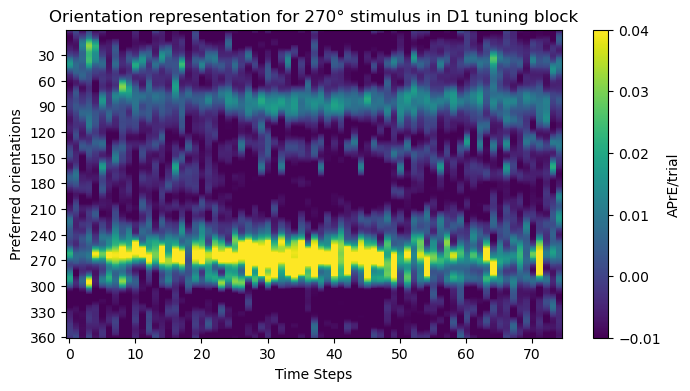

In [5]:
recording_day = 'D1'
visual_stimulus = 270
title = 'Orientation representation for 270° stimulus in D1 tuning block'

relevant_experiment_ids = retrieve_recording_day_experiment_ids(recording_day, tables)
trial_bank = construct_tuning_trial_bank(relevant_experiment_ids, recording_day, visual_stimulus, tables)

admissible_neurons = retrieve_admissible_neurons(relevant_experiment_ids, tables)
experiment_data = load_all_experiments_into_memory(trial_bank, tqdm_disable=False)

trial_matrix = construct_orientation_representation(admissible_neurons, experiment_data, trial_length, tqdm_disable=False)
plot_orientation_representation(trial_matrix, title)

See how the activation for the 270° stimulus is outside of the stimulus presentation window, frames 25-50.

To debug this, let's use the procedure outlined in Corbo's updates manuscript.

## Workbench

In [6]:
experiments_relevant = df_trialtable[
    (df_trialtable['Behav_Cond'] == 'D1')
]

relevant_experiment_ids = list(experiments_relevant['Experiment'].unique())
relevant_experiment_ids

['B10_110920',
 'F07_42021_',
 'C02_121020',
 'C05_121020',
 'F05_42021_',
 'F06_42121_',
 'F09_42021_',
 'F10_42121_',
 'F17_42021_',
 'F19_42021_']

In [7]:
trial_bank = {}

for experiment_id in relevant_experiment_ids:
    df_experiment = df_trialtable[df_trialtable['Experiment'] == experiment_id]
    df_relevant_trials = df_experiment[
        (df_experiment['Block'] == 'Orientation Tuning') &\
        (df_experiment['Visual_Stim'] == 270)
    ]
    trials = np.sort(df_relevant_trials['Trial'].unique())
    trial_bank[experiment_id] = trials

trial_bank

{'B10_110920': array([  4,  16,  34,  48,  57,  70,  75,  89,  98, 425, 434, 445, 462,
        468, 481, 496, 509, 523, 536]),
 'F07_42021_': array([201, 213, 226, 244, 250, 260, 280, 290, 297, 308]),
 'C02_121020': array([  9,  19,  25,  42,  58,  65,  75,  96, 104, 117, 329, 337, 343,
        366, 376, 384, 399, 405, 416, 432]),
 'C05_121020': array([  8,  15,  31,  47,  52,  64,  73,  93,  97, 118, 321, 336, 344,
        355, 375, 386, 394, 411, 422, 430]),
 'F05_42021_': array([208, 221, 233, 239, 251, 265, 279, 289, 306, 311]),
 'F06_42121_': array([300, 320, 325, 342, 353, 367, 381, 385, 400, 415]),
 'F09_42021_': array([249, 270, 276, 290, 302, 312, 331, 339, 345, 364]),
 'F10_42121_': array([235, 253, 258, 278, 292, 299, 313, 325, 339, 351]),
 'F17_42021_': array([300]),
 'F19_42021_': array([234, 239, 253, 264, 284, 287, 304, 317, 326, 337])}

The 'F17_42021_' experiment is fishy.

In [8]:
admissible_neurons = df_celltable[
    (df_celltable['Experiment'].isin(relevant_experiment_ids)) &\
    (~df_celltable['Best_Fit_spikes_2'].isna()) &\
    (df_celltable['DeconvCorr'] > 0.8) &\
    (df_celltable['isCell'] > 0.8) &\
    (df_celltable['spikeProb_TCTrials'] > 0.1) &\
    (df_celltable['roundness'] > 0.20) &\
    (df_celltable['nPix']*df_celltable['magFactor'] > 15)
]
len(admissible_neurons)

2007

In [9]:
experiment_data = {}

for experiment_id in tqdm(trial_bank.keys(), disable=False):
    hdf5_path = os.path.join(
        DATASET1['CellTrialTabel_csv_path'], 
        experiment_id[:3], 
        f"{experiment_id}.h5"
    )

    with h5py.File(hdf5_path, 'r') as hdf:
        # Load all trials for the current experiment
        experiment_data[experiment_id] = {
            f'trial_{trial_id}': hdf[f'trial_{trial_id}'][:]
            for trial_id in trial_bank[experiment_id]
        }

100%|███████████████████████████████████████████| 10/10 [00:15<00:00,  1.58s/it]


In [10]:
trial_matrix = np.zeros((360, trial_length,))
count_array = np.zeros(360)
error_count = 0

for row in tqdm(admissible_neurons.itertuples(), disable=False):
    experiment_id = row.Experiment
    cell_index = row.Cell - 1
    cell_spike_trace = np.zeros(trial_length)
    orientation_index = int(row.Pref_Orientation_spikes_2) - 1

    for trial_id in experiment_data[experiment_id]:
        spike_trace = experiment_data[experiment_id][trial_id][:,cell_index]
        spike_trace = enforce_spike_trace_length(spike_trace, trial_length)
        cell_spike_trace += spike_trace

    if len(experiment_data[experiment_id].keys()) > 0:
        cell_spike_trace = cell_spike_trace / len(experiment_data[experiment_id].keys())
        cell_spike_trace = cell_spike_trace - np.mean(cell_spike_trace[:24]) # Subtracting the mean from the first 23 frames, i.e. "the baseline"
        trial_matrix[orientation_index, :] += cell_spike_trace
        count_array[orientation_index] += 1
    else:
        error_count += 1

safe_count_array = np.where(count_array == 0, 1, count_array)
trial_matrix = trial_matrix / safe_count_array[:, np.newaxis]
#trial_matrix = trial_matrix - np.mean(trial_matrix) # Baseline subtracting trial matrix
trial_matrix = gaussian_filter1d(trial_matrix, sigma=6, axis=0, mode='wrap')
trial_matrix.shape

2007it [00:00, 5849.84it/s]


(360, 75)

In [11]:
print(f'There were {error_count} error neurons')

There were 0 error neurons


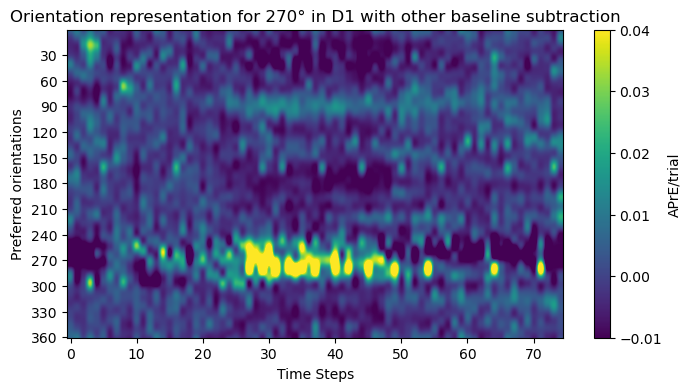

In [12]:
plt.figure(figsize=(8, 4))
plt.imshow(
    trial_matrix,
    aspect='auto',
    cmap='viridis',
    interpolation=None,
    vmin=-0.01,
    vmax=0.04
)
plt.colorbar(label='APrE/trial')
plt.title('Orientation representation for 270° in D1 with other baseline subtraction')
plt.xlabel('Time Steps')
plt.ylabel('Preferred orientations')

# Set the y-axis ticks and labels
y_ticks = np.arange(29, 360, 30)  # Ticks starting from 30 to 360 with steps of 30
plt.yticks(y_ticks, y_ticks + 1)  # Adding 1 to range because the index is zero-based

plt.show()

In [13]:
from matplotlib.colors import LinearSegmentedColormap

cm_data = [[0.2422, 0.1504, 0.6603],
[0.2444, 0.1534, 0.6728],
[0.2464, 0.1569, 0.6847],
[0.2484, 0.1607, 0.6961],
[0.2503, 0.1648, 0.7071],
[0.2522, 0.1689, 0.7179],
[0.254, 0.1732, 0.7286],
[0.2558, 0.1773, 0.7393],
[0.2576, 0.1814, 0.7501],
[0.2594, 0.1854, 0.761],
[0.2611, 0.1893, 0.7719],
[0.2628, 0.1932, 0.7828],
[0.2645, 0.1972, 0.7937],
[0.2661, 0.2011, 0.8043],
[0.2676, 0.2052, 0.8148],
[0.2691, 0.2094, 0.8249],
[0.2704, 0.2138, 0.8346],
[0.2717, 0.2184, 0.8439],
[0.2729, 0.2231, 0.8528],
[0.274, 0.228, 0.8612],
[0.2749, 0.233, 0.8692],
[0.2758, 0.2382, 0.8767],
[0.2766, 0.2435, 0.884],
[0.2774, 0.2489, 0.8908],
[0.2781, 0.2543, 0.8973],
[0.2788, 0.2598, 0.9035],
[0.2794, 0.2653, 0.9094],
[0.2798, 0.2708, 0.915],
[0.2802, 0.2764, 0.9204],
[0.2806, 0.2819, 0.9255],
[0.2809, 0.2875, 0.9305],
[0.2811, 0.293, 0.9352],
[0.2813, 0.2985, 0.9397],
[0.2814, 0.304, 0.9441],
[0.2814, 0.3095, 0.9483],
[0.2813, 0.315, 0.9524],
[0.2811, 0.3204, 0.9563],
[0.2809, 0.3259, 0.96],
[0.2807, 0.3313, 0.9636],
[0.2803, 0.3367, 0.967],
[0.2798, 0.3421, 0.9702],
[0.2791, 0.3475, 0.9733],
[0.2784, 0.3529, 0.9763],
[0.2776, 0.3583, 0.9791],
[0.2766, 0.3638, 0.9817],
[0.2754, 0.3693, 0.984],
[0.2741, 0.3748, 0.9862],
[0.2726, 0.3804, 0.9881],
[0.271, 0.386, 0.9898],
[0.2691, 0.3916, 0.9912],
[0.267, 0.3973, 0.9924],
[0.2647, 0.403, 0.9935],
[0.2621, 0.4088, 0.9946],
[0.2591, 0.4145, 0.9955],
[0.2556, 0.4203, 0.9965],
[0.2517, 0.4261, 0.9974],
[0.2473, 0.4319, 0.9983],
[0.2424, 0.4378, 0.9991],
[0.2369, 0.4437, 0.9996],
[0.2311, 0.4497, 0.9995],
[0.225, 0.4559, 0.9985],
[0.2189, 0.462, 0.9968],
[0.2128, 0.4682, 0.9948],
[0.2066, 0.4743, 0.9926],
[0.2006, 0.4803, 0.9906],
[0.195, 0.4861, 0.9887],
[0.1903, 0.4919, 0.9867],
[0.1869, 0.4975, 0.9844],
[0.1847, 0.503, 0.9819],
[0.1831, 0.5084, 0.9793],
[0.1818, 0.5138, 0.9766],
[0.1806, 0.5191, 0.9738],
[0.1795, 0.5244, 0.9709],
[0.1785, 0.5296, 0.9677],
[0.1778, 0.5349, 0.9641],
[0.1773, 0.5401, 0.9602],
[0.1768, 0.5452, 0.956],
[0.1764, 0.5504, 0.9516],
[0.1755, 0.5554, 0.9473],
[0.174, 0.5605, 0.9432],
[0.1716, 0.5655, 0.9393],
[0.1686, 0.5705, 0.9357],
[0.1649, 0.5755, 0.9323],
[0.161, 0.5805, 0.9289],
[0.1573, 0.5854, 0.9254],
[0.154, 0.5902, 0.9218],
[0.1513, 0.595, 0.9182],
[0.1492, 0.5997, 0.9147],
[0.1475, 0.6043, 0.9113],
[0.1461, 0.6089, 0.908],
[0.1446, 0.6135, 0.905],
[0.1429, 0.618, 0.9022],
[0.1408, 0.6226, 0.8998],
[0.1383, 0.6272, 0.8975],
[0.1354, 0.6317, 0.8953],
[0.1321, 0.6363, 0.8932],
[0.1288, 0.6408, 0.891],
[0.1253, 0.6453, 0.8887],
[0.1219, 0.6497, 0.8862],
[0.1185, 0.6541, 0.8834],
[0.1152, 0.6584, 0.8804],
[0.1119, 0.6627, 0.877],
[0.1085, 0.6669, 0.8734],
[0.1048, 0.671, 0.8695],
[0.1009, 0.675, 0.8653],
[0.0964, 0.6789, 0.8609],
[0.0914, 0.6828, 0.8562],
[0.0855, 0.6865, 0.8513],
[0.0789, 0.6902, 0.8462],
[0.0713, 0.6938, 0.8409],
[0.0628, 0.6972, 0.8355],
[0.0535, 0.7006, 0.8299],
[0.0433, 0.7039, 0.8242],
[0.0328, 0.7071, 0.8183],
[0.0234, 0.7103, 0.8124],
[0.0155, 0.7133, 0.8064],
[0.0091, 0.7163, 0.8003],
[0.0046, 0.7192, 0.7941],
[0.0019, 0.722, 0.7878],
[0.0009, 0.7248, 0.7815],
[0.0018, 0.7275, 0.7752],
[0.0046, 0.7301, 0.7688],
[0.0094, 0.7327, 0.7623],
[0.0162, 0.7352, 0.7558],
[0.0253, 0.7376, 0.7492],
[0.0369, 0.74, 0.7426],
[0.0504, 0.7423, 0.7359],
[0.0638, 0.7446, 0.7292],
[0.077, 0.7468, 0.7224],
[0.0899, 0.7489, 0.7156],
[0.1023, 0.751, 0.7088],
[0.1141, 0.7531, 0.7019],
[0.1252, 0.7552, 0.695],
[0.1354, 0.7572, 0.6881],
[0.1448, 0.7593, 0.6812],
[0.1532, 0.7614, 0.6741],
[0.1609, 0.7635, 0.6671],
[0.1678, 0.7656, 0.6599],
[0.1741, 0.7678, 0.6527],
[0.1799, 0.7699, 0.6454],
[0.1853, 0.7721, 0.6379],
[0.1905, 0.7743, 0.6303],
[0.1954, 0.7765, 0.6225],
[0.2003, 0.7787, 0.6146],
[0.2061, 0.7808, 0.6065],
[0.2118, 0.7828, 0.5983],
[0.2178, 0.7849, 0.5899],
[0.2244, 0.7869, 0.5813],
[0.2318, 0.7887, 0.5725],
[0.2401, 0.7905, 0.5636],
[0.2491, 0.7922, 0.5546],
[0.2589, 0.7937, 0.5454],
[0.2695, 0.7951, 0.536],
[0.2809, 0.7964, 0.5266],
[0.2929, 0.7975, 0.517],
[0.3052, 0.7985, 0.5074],
[0.3176, 0.7994, 0.4975],
[0.3301, 0.8002, 0.4876],
[0.3424, 0.8009, 0.4774],
[0.3548, 0.8016, 0.4669],
[0.3671, 0.8021, 0.4563],
[0.3795, 0.8026, 0.4454],
[0.3921, 0.8029, 0.4344],
[0.405, 0.8031, 0.4233],
[0.4184, 0.803, 0.4122],
[0.4322, 0.8028, 0.4013],
[0.4463, 0.8024, 0.3904],
[0.4608, 0.8018, 0.3797],
[0.4753, 0.8011, 0.3691],
[0.4899, 0.8002, 0.3586],
[0.5044, 0.7993, 0.348],
[0.5187, 0.7982, 0.3374],
[0.5329, 0.797, 0.3267],
[0.547, 0.7957, 0.3159],
[0.5609, 0.7943, 0.305],
[0.5748, 0.7929, 0.2941],
[0.5886, 0.7913, 0.2833],
[0.6024, 0.7896, 0.2726],
[0.6161, 0.7878, 0.2622],
[0.6297, 0.7859, 0.2521],
[0.6433, 0.7839, 0.2423],
[0.6567, 0.7818, 0.2329],
[0.6701, 0.7796, 0.2239],
[0.6833, 0.7773, 0.2155],
[0.6963, 0.775, 0.2075],
[0.7091, 0.7727, 0.1998],
[0.7218, 0.7703, 0.1924],
[0.7344, 0.7679, 0.1852],
[0.7468, 0.7654, 0.1782],
[0.759, 0.7629, 0.1717],
[0.771, 0.7604, 0.1658],
[0.7829, 0.7579, 0.1608],
[0.7945, 0.7554, 0.157],
[0.806, 0.7529, 0.1546],
[0.8172, 0.7505, 0.1535],
[0.8281, 0.7481, 0.1536],
[0.8389, 0.7457, 0.1546],
[0.8495, 0.7435, 0.1564],
[0.86, 0.7413, 0.1587],
[0.8703, 0.7392, 0.1615],
[0.8804, 0.7372, 0.165],
[0.8903, 0.7353, 0.1695],
[0.9, 0.7336, 0.1749],
[0.9093, 0.7321, 0.1815],
[0.9184, 0.7308, 0.189],
[0.9272, 0.7298, 0.1973],
[0.9357, 0.729, 0.2061],
[0.944, 0.7285, 0.2151],
[0.9523, 0.7284, 0.2237],
[0.9606, 0.7285, 0.2312],
[0.9689, 0.7292, 0.2373],
[0.977, 0.7304, 0.2418],
[0.9842, 0.733, 0.2446],
[0.99, 0.7365, 0.2429],
[0.9946, 0.7407, 0.2394],
[0.9966, 0.7458, 0.2351],
[0.9971, 0.7513, 0.2309],
[0.9972, 0.7569, 0.2267],
[0.9971, 0.7626, 0.2224],
[0.9969, 0.7683, 0.2181],
[0.9966, 0.774, 0.2138],
[0.9962, 0.7798, 0.2095],
[0.9957, 0.7856, 0.2053],
[0.9949, 0.7915, 0.2012],
[0.9938, 0.7974, 0.1974],
[0.9923, 0.8034, 0.1939],
[0.9906, 0.8095, 0.1906],
[0.9885, 0.8156, 0.1875],
[0.9861, 0.8218, 0.1846],
[0.9835, 0.828, 0.1817],
[0.9807, 0.8342, 0.1787],
[0.9778, 0.8404, 0.1757],
[0.9748, 0.8467, 0.1726],
[0.972, 0.8529, 0.1695],
[0.9694, 0.8591, 0.1665],
[0.9671, 0.8654, 0.1636],
[0.9651, 0.8716, 0.1608],
[0.9634, 0.8778, 0.1582],
[0.9619, 0.884, 0.1557],
[0.9608, 0.8902, 0.1532],
[0.9601, 0.8963, 0.1507],
[0.9596, 0.9023, 0.148],
[0.9595, 0.9084, 0.145],
[0.9597, 0.9143, 0.1418],
[0.9601, 0.9203, 0.1382],
[0.9608, 0.9262, 0.1344],
[0.9618, 0.932, 0.1304],
[0.9629, 0.9379, 0.1261],
[0.9642, 0.9437, 0.1216],
[0.9657, 0.9494, 0.1168],
[0.9674, 0.9552, 0.1116],
[0.9692, 0.9609, 0.1061],
[0.9711, 0.9667, 0.1001],
[0.973, 0.9724, 0.0938],
[0.9749, 0.9782, 0.0872],
[0.9769, 0.9839, 0.0805]]

parula_map = LinearSegmentedColormap.from_list('parula', cm_data)

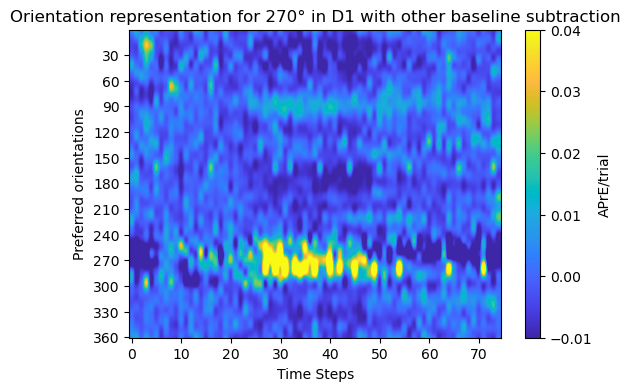

In [14]:
plt.figure(figsize=(6, 4))
plt.imshow(
    trial_matrix,
    aspect='auto',
    cmap=parula_map,
    interpolation=None,
    vmin=-0.01,
    vmax=0.04
)
plt.colorbar(label='APrE/trial')
plt.title('Orientation representation for 270° in D1 with other baseline subtraction')
plt.xlabel('Time Steps')
plt.ylabel('Preferred orientations')

# Set the y-axis ticks and labels
y_ticks = np.arange(29, 360, 30)  # Ticks starting from 30 to 360 with steps of 30
plt.yticks(y_ticks, y_ticks + 1)  # Adding 1 to range because the index is zero-based

plt.show()